Mon Dec 14 00:17:02 2020

annulus_flow_test:
  Python version: 3.7.2
  FENICS version 2019.1.0
  Navier-Stokes flow in an off-center annulus.


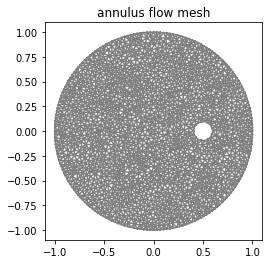

  Solve at time t = 0.01
  Solve at time t = 0.02
  Solve at time t = 0.03
  Solve at time t = 0.04
  Solve at time t = 0.05
  Solve at time t = 0.06
  Solve at time t = 0.07
  Solve at time t = 0.08
  Solve at time t = 0.09
  Solve at time t = 0.1

annulus_flow_test:
  Normal end of execution.
Mon Dec 14 00:17:14 2020


In [3]:
from dolfin import *
from mshr import *

def annulus_flow ( ):

#*****************************************************************************80
#
## annulus_flow solves Navier-Stokes flow in an off-center annulus.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    27 November 2018
#
#  Author:
#
#    Michael Schneier
#
#  Modifier:
#
#    John Burkardt
#
  import numpy as np
  import matplotlib.pyplot as plt
  from numpy import linalg as LA
  from scipy.sparse.linalg.eigen.arpack import eigsh
  from scipy import sparse, io
  import time
  import pdb
#
#  Time info and viscosity coefficents
#
  t_init = 0.0
  t_final = 10.0
  t_num = 1000
#
#  Reduce computational time range to 100th of original for example run.
#
  t_init = 0.0
  t_final = 0.1
  t_num = 10
#
#  Set other time parameters.
#
  dt = ( t_final - t_init ) / t_num
  eps_be = dt
  t = t_init
#
#  Viscosity coefficient.
#
  nu = 0.001
#
#  Generate the mesh.
#
  circle_outx = 0.0
  circle_outy = 0.0
  circle_outr = 1.0
  circle_inx = 0.5
  circle_iny = 0.0
  circle_inr = 0.1

  domain = Circle ( Point(circle_outx,circle_outy), circle_outr ) \
         - Circle ( Point(circle_inx,circle_iny), circle_inr )

  mesh = generate_mesh ( domain, 30 )
#
#  Plot the mesh.
#
  plot ( mesh, title = 'annulus flow mesh' )
#  filename = 'annulus_flow_mesh.png'
#  plt.savefig ( filename )
#  print ( '  Graphics saved as "%s"' % ( filename ) )
  plt.show()
  plt.close()
#
#  Declare Finite Elements for velocity, pressure, and Taylor-Hood.
#
  P2 = VectorElement ( "P", triangle, 2 )
  P1 = FiniteElement ( "P", triangle, 1 )
  TH = P2 * P1
#
#  Declare Function Spaces for velocity, pressure, and Taylor-Hood.
#
  V = VectorFunctionSpace ( mesh, "P", 2 )
  Q = FunctionSpace ( mesh, "P", 1 )
  W = FunctionSpace ( mesh, TH )
#
#  Declare formal Finite Element Functions
#
  ( u, p ) = TrialFunctions ( W )
  ( v, q ) = TestFunctions ( W )
#
#  Define some functions.
#
  w = Function ( W )
  u0 = Function ( V )
  p0 = Function ( Q )
#
#  Macros needed for weak formulation.
#
  def contract(u,v):
    return inner(nabla_grad(u),nabla_grad(v))

  def b(u,v,w):
    return 0.5*(inner(dot(u,nabla_grad(v)),w)-inner(dot(u,nabla_grad(w)),v))
#
#  Declare Boundary Conditions.
#
  def u0_boundary(x, on_boundary):
    return on_boundary

  noslip = Constant((0.0, 0.0))

  def lower_boundary_fixed_point(x,on_boundary):
    tol=1E-15
    return (abs(x[1]) < tol) and (abs(x[0]-0.5)<tol)

  bc0 = DirichletBC ( W.sub(0), noslip, u0_boundary )
  bc_test = DirichletBC ( W.sub(1), Constant(0.0), lower_boundary_fixed_point, method = 'pointwise' )
  bcs = [ bc0, bc_test ]
#
#  Generate Initial Conditions
#
#  Right hand side
#
  f_stokes = Expression ( ( "-1*4*x[1]*(1 - x[0]*x[0] - x[1]*x[1])","4*x[0]*(1 - x[0]*x[0] - x[1]*x[1])"), pi=np.pi, degree = 4 )
  f = Expression ( ( "-1*4*x[1]*(1 - x[0]*x[0] - x[1]*x[1])","4*x[0]*(1 - x[0]*x[0] - x[1]*x[1])"), pi=np.pi, degree = 4 )
#
#  Set up Stokes problem for IC
#
#  Functions for Stokes Equation
#
  (us, ps) = TrialFunctions(W)
  (vs, qs) = TestFunctions(W)
  r = Function(W)

  LStokes = inner(f_stokes, vs) * dx
  Stokes = (inner(grad(us), grad(vs)) - div(vs)*ps + qs*div(us)) * dx
  solve(Stokes == LStokes, r, bcs,solver_parameters=dict(linear_solver="lu"))
  assign(u0,r.sub(0))
  assign(p0,r.sub(1))
#
#  weak form NSE
#
  NSE = (1./dt)*inner(u,v)*dx + b(u0,u,v)*dx + nu*contract(u,v)*dx - div(v)*p*dx + q*div(u)*dx
  LNSE = inner(f,v)*dx + (1./dt)*inner(u0,v)*dx
#
#  Set up ParaView plot files.
#
#  velocity_paraview_file = File("velocity_solution.pvd")
#  pressure_paraview_file = File("pressure_solution.pvd")
#
#  Take time steps.
#
  for t_step in range ( 0, t_num ):
    t = t + dt
    print ( '  Solve at time t = %g' % ( t ) )
    A, b = assemble_system ( NSE, LNSE, bcs )
    solve ( A, w.vector(), b )
    assign ( u0, w.sub(0) )
    assign ( p0, w.sub(1) )
#
#  Save solutions to ParaView File
#
#    velocity_paraview_file << ( u0, t )
#    pressure_paraview_file << ( p0, t )

  return

def annulus_flow_test ( ):

#*****************************************************************************80
#
## annulus_flow_test tests annulus_flow.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    27 November 2018
#
#  Author:
#
#    Original version by Michael Schneier
#    This version by John Burkardt
#
  import platform
#
#  Report level = only warnings or higher.
#
  level = 30
  set_log_level ( level )

  print ( '' )
  print ( 'annulus_flow_test:' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  FENICS version %s'% ( dolfin.__version__ ) )
  print ( '  Navier-Stokes flow in an off-center annulus.' )

  annulus_flow ( )
#
#  Terminate.
#
  print ( '' )
  print ( 'annulus_flow_test:' )
  print ( '  Normal end of execution.' )
  return

if ( __name__ == '__main__' ):
  import time
  print ( time.ctime ( time.time() ) )
  annulus_flow_test ( )
  print ( time.ctime ( time.time() ) )

